# EYE FOR BLIND

**Problem statement:** 

To create a deep learning model which can explain the content of an image in the form of speech through Caption generation with attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

This problem statement is an application of both Deep Learning and Natural Language processing. The features of an image will be extracted by CNN based encoder and this will be decoded by an RNN model

The dataset is taken from the <a href='https://www.kaggle.com/adityajn105/flickr8k'>**Kaggle website**</a> and it consists of sentence-based image description having a list of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events of the image.

**Project Pipeline**

The project pipeline can be briefly summarized in the following four steps:

- Data Understanding: Here, you need to load the data and understand the representation 
- Data preprocessing: In this step, you will process both images & captions to the desired format.
- Train/Test Split: Combine both images & captions to create the train & test dataset.
- Model-Building: This is the stage where you will create your image captioning model by building Encoder , Attention & Decoder model.
- Model Evaluation: Evaluate the model.

## Import all the required libraries

In [98]:
import numpy as np
import pandas as pd
import os
import re
import glob
import datetime
import pickle
from pickle import dump, load
import sys, time, os, warnings
from PIL import Image
np.random.seed(30)
import random
random.seed(30)
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as k
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
tf.random.set_seed(30)

from nltk.translate.bleu_score import sentence_bleu

import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

In [99]:
pd.set_option('display.max_colwidth',100)

## Data understanding


**Import the images -**

In [100]:
#Import the images -

images='/content/drive/MyDrive/dataset_colab/upload_colab/Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


**Read captions in a dataframe**

In [101]:
df = pd.read_csv('/content/drive/MyDrive/dataset_colab/upload_colab/captions.txt')

print(df.shape)
df.head(3)

(40455, 2)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


**Visualise both the images & text present in the dataset**

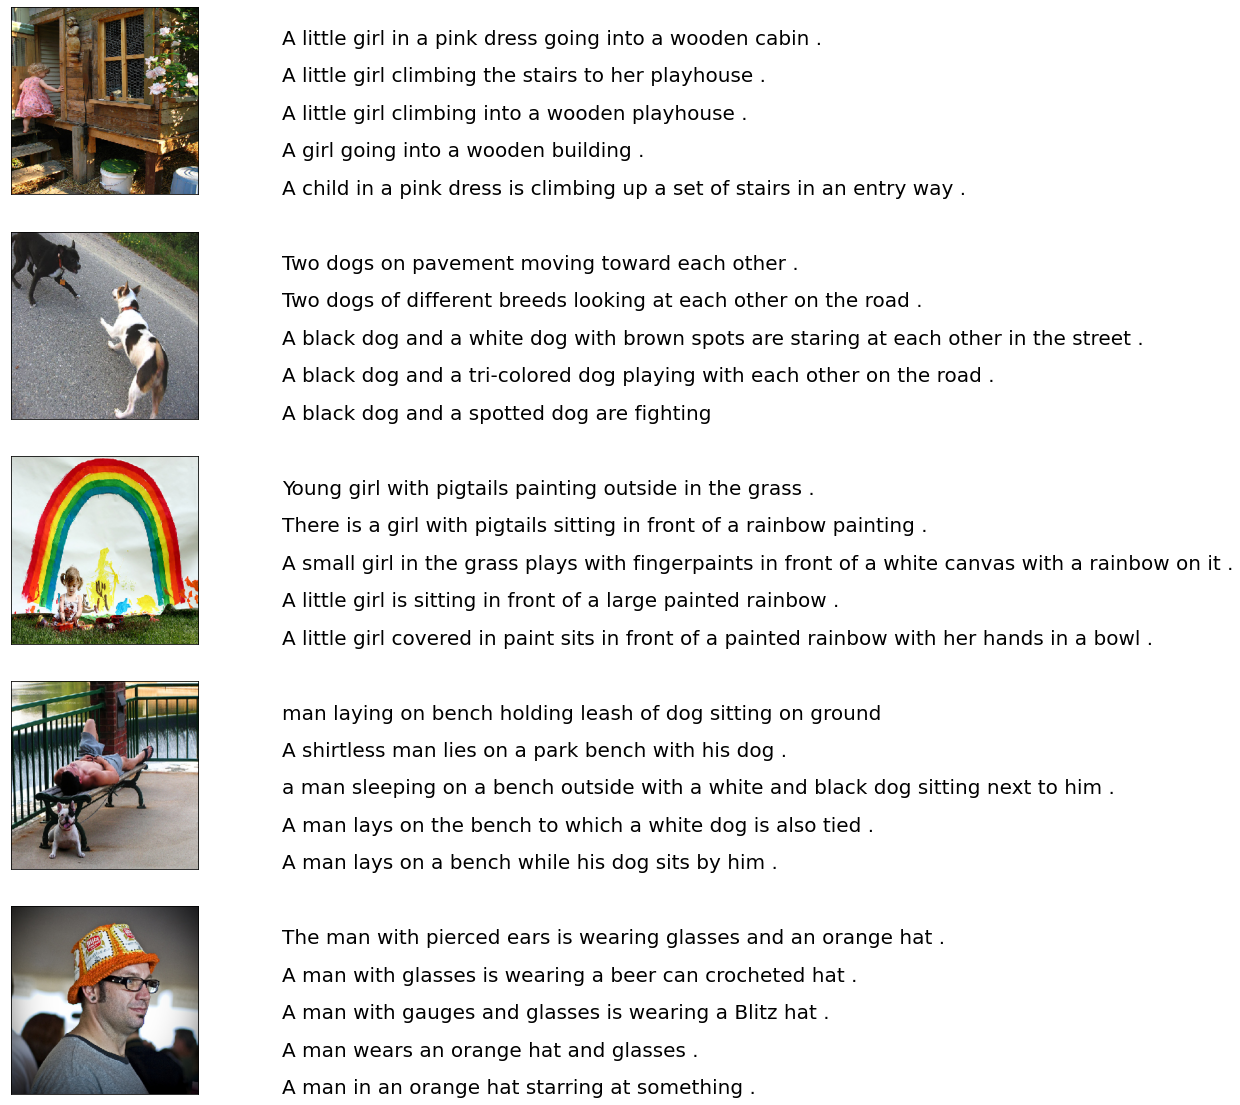

In [ ]:
img_filenames = np.unique(df.image.values)
npic = 5
npix = 299
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in img_filenames[0:5]:
    filename = images + '/' + jpgfnm
    captions = list(df.loc[df.image == jpgfnm, 'caption'])
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

**Create a dataframe which summarizes the image, path & captions as a dataframe**

In [102]:
path = '/content/drive/MyDrive/dataset_colab/upload_colab/Images/'

df['path'] = path + df['image']
df.head(3)

,image,caption,path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg


In [103]:
#store all the image id here
all_img_id= list(df.image)  

#store all the image path here
all_img_vector= list(df.path)  

In [ ]:
#check if all image has corresponding caption -

missing = []
for img in all_imgs:
    x = img.split('/')[7]
    if x not in all_img_id:
        missing.append(x)
        
print(len(missing))

0


**Clean caption text data**

In [104]:
import string
from string import digits

exclude = set(string.punctuation) # Set of all special characters
df.caption = df.caption.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

remove_digits = str.maketrans('', '', digits)
df.caption = df.caption.apply(lambda x: x.translate(remove_digits))

df.caption = df.caption.apply(lambda x: x.lower())

df.caption = df.caption.apply(lambda x: x.strip())

df.caption = df.caption.apply(lambda x: re.sub(" +", " ", x))

df.caption = df.caption.apply(lambda x: re.sub(r"[^a-zA-Z?.!,¿]+", " ", x))

df.caption = df.caption.apply(lambda x: ' '.join(ch for ch in x.split(' ') if len(ch) > 1))

In [105]:
df.head(3)

,image,caption,path
0,1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of stairs in an entry way,/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,girl going into wooden building,/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse,/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg


In [ ]:
df.shape

(40455, 3)

In [106]:
#Exclude captions having words less than 2 -

df = df[~df['caption'].str.split().str.len().lt(2)]

In [ ]:
df.shape

(40448, 3)

In [ ]:
# Create a count for each word - 

import collections

vocabulary = []
for lines in df.caption:
    for word in lines.split(' '):
        vocabulary.append(word)

print(len(vocabulary))

val_count = collections.Counter(vocabulary)

372905


In [ ]:
#Check the top 30 occuring words in the captions:

top_30 = {k: v for k, v in sorted(val_count.items(), key=lambda item: item[1], reverse=True)[:30]}
top_30

{'an': 2432,
 'and': 8851,
 'are': 3504,
 'at': 2914,
 'black': 3832,
 'blue': 2268,
 'boy': 3581,
 'brown': 2563,
 'dog': 8136,
 'dogs': 2125,
 'girl': 3328,
 'his': 2357,
 'in': 18974,
 'is': 9345,
 'man': 7265,
 'of': 6713,
 'on': 10743,
 'people': 2883,
 'red': 2672,
 'running': 2073,
 'the': 18418,
 'through': 2032,
 'to': 3173,
 'two': 5638,
 'water': 2783,
 'wearing': 3062,
 'white': 3940,
 'with': 7765,
 'woman': 3402,
 'young': 2630}

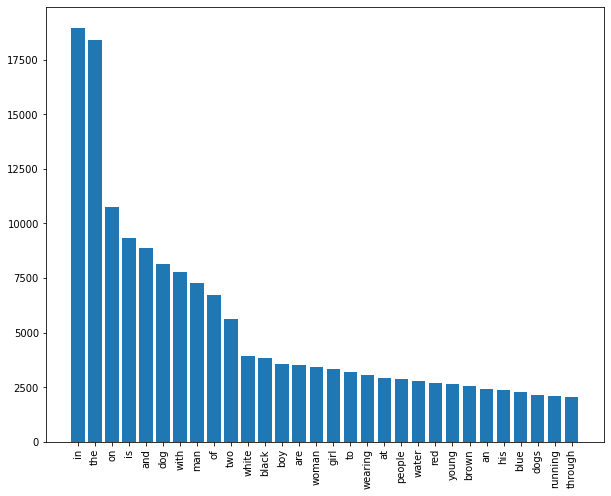

In [ ]:
#Visualise the top 30 occuring words in the captions:
plt.figure(figsize=(10, 8))
plt.bar(range(len(top_30)), top_30.values(), align='center')
plt.xticks(range(len(top_30)), list(top_30.keys()),rotation=90)

plt.show()

In [107]:
#add <start> and <end> tokens with caption -

df.caption = '<start> ' + df.caption + ' <end>'
df.head(3)

,image,caption,path
0,1000268201_693b08cb0e.jpg,<start> child in pink dress is climbing up set of stairs in an entry way <end>,/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,<start> girl going into wooden building <end>,/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg,<start> little girl climbing into wooden playhouse <end>,/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg


In [108]:
#Create a list of all the captions -
all_captions = list(df.caption)

all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tricolored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [109]:
#Create a list of all the images  -
all_img_name_vector = list(df.path)

all_img_name_vector[:10]

['/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/1001773457_577c3a7d70.jpg']

In [110]:
#Create a list of unique vocabulary -
clean_vocabulary = []
for txt in df.caption.values:
    clean_vocabulary.extend(txt.split())
    
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8767


In [ ]:
print("Total captions present in the dataset: "+ str(len(all_captions)))
print("Total images present in the dataset: " + str(len(all_img_name_vector)))

Total captions present in the dataset: 40448
Total images present in the dataset: 40448


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace out of vocabulary (oov) words as <unk> .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [111]:
top_k = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token='<unk>',
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

In [112]:
tokenizer.fit_on_texts(all_captions)

``fit_on_texts`` creates word_index and index_word mappings:

In [2]:
#tokenizer.word_index

In [3]:
#tokenizer.index_word

``texts_to_sequences`` Transforms each text in texts to a sequence of integers. So it takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.

In [113]:
train_seqs = tokenizer.texts_to_sequences(all_captions)

In [ ]:
train_seqs[:5]

[[2, 42, 4, 90, 169, 7, 119, 53, 394, 12, 391, 4, 28, 1, 692, 3],
 [2, 19, 313, 64, 193, 117, 3],
 [2, 40, 19, 119, 64, 193, 2423, 3],
 [2, 40, 19, 119, 5, 391, 20, 60, 2423, 3],
 [2, 40, 19, 4, 90, 169, 313, 64, 193, 2985, 3]]

In [114]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [115]:
train_seqs = tokenizer.texts_to_sequences(all_captions)

In [116]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
all_captions[:3]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>']

In [ ]:
train_seqs[:3]

[[2, 42, 4, 90, 169, 7, 119, 53, 394, 12, 391, 4, 28, 1, 692, 3],
 [2, 19, 313, 64, 193, 117, 3],
 [2, 40, 19, 119, 64, 193, 2423, 3]]

In [ ]:
cap_vector[:3]

array([[   2,   42,    4,   90,  169,    7,  119,   53,  394,   12,  391,
           4,   28,    1,  692,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   2,   19,  313,   64,  193,  117,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   2,   40,   19,  119,   64,  193, 2423,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)

In [ ]:
len(cap_vector[0])

34

In [117]:
#Check maximum and minimum length of words in caption -
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
    return min(len(t) for t in tensor)
   
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 34 : 4


## Pre-processing the images

1. Resize them into the shape of (299, 299) <br>
2. Use transfer learning to extract feature vectors of the images using pretrained InceptionV3 model
 

In [118]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)

    return img, image_path

In [119]:
image_model = InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
len(sorted(set(all_img_name_vector)))

8091

In [120]:
#Create a tf.data dataset for images and map each image name to the function to load the image:

encode_train = sorted(set(all_img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [ ]:
#image_dataset -> consists of image array and path; 8091 / 64 = 126.4
len(image_dataset)

127

In [ ]:
#Save the extracted features which can be used later -
#https://stackoverflow.com/questions/40388792/how-to-decode-a-numpy-array-of-encoded-literals-strings-in-python3-attributeerr

%%time
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img) # shape of extracted feature -> [64, 8, 8, 2048]
    
    batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))  #shape -> [64, 64, 2048]
    
    for bf, p in zip(batch_features, path):
        #save the image features as list
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [26:15<00:00, 12.40s/it]

CPU times: user 44.2 s, sys: 4.14 s, total: 48.4 s
Wall time: 26min 15s


## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


## Create the train & test data

In [121]:
#Create the train-test spliit using 80-20 ratio & random state = 42
img_name_train, img_name_val, cap_train, cap_val = train_test_split(all_img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [122]:
print(len(img_name_train), len(img_name_val))
print(len(cap_train), len(cap_val))

32358 8090
32358 8090


In [ ]:
img_name_val[:5]

['/content/drive/MyDrive/dataset_colab/upload_colab/Images/501650847_b0beba926c.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/3240014971_ee2ea8406f.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/1675679141_36c9bc2969.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/1093716555_801aacef79.jpg',
 '/content/drive/MyDrive/dataset_colab/upload_colab/Images/2157173498_2eea42ee38.jpg']

**Define the training parameters:**

In [123]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
enc_units = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8770


In [124]:
train_num_steps = len(img_name_train) // BATCH_SIZE
train_num_steps

505

In [125]:
test_num_steps = len(img_name_val) // BATCH_SIZE
test_num_steps

126

In [126]:
#verify the count of saved image features -
images='/content/drive/MyDrive/dataset_colab/upload_colab/Images/'

all_npy = glob.glob(images + '/*.npy',recursive=True)
print("The total images present in the dataset: {}".format(len(all_npy)))

The total images present in the dataset: 8091


In [127]:
#function to read the saved iage features and returns image feature and caption -
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    
    return img_tensor, cap

In [128]:
#Create dataset to train the model -
dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset_train = dataset_train.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),
                                                num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [129]:
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset_train

<BatchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [130]:
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [131]:
sample_img_batch, sample_cap_batch = next(iter(dataset_train))

sample_img_batch.shape, sample_cap_batch.shape

(TensorShape([64, 64, 2048]), TensorShape([64, 34]))

In [132]:
#Create dataset to test the model -
dataset_test = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
dataset_test = dataset_test.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),
                                                num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [133]:
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=True)

In [134]:
dataset_test = dataset_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
dataset_test

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

## Model Building


Build the Encoder, Attention model & Decoder

### Encoder

In [135]:
class Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, enc_units):
        super(Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(enc_units)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [136]:
encoder = Encoder(enc_units)

In [137]:
# sample input

sample_feature = encoder(sample_img_batch)

print('Encoder input shape: {}'.format(sample_img_batch.shape))
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_feature.shape))

Encoder input shape: (64, 64, 2048)
Encoder output shape: (batch size, sequence length, units) (64, 64, 256)


### Attention model

In [138]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, enc_units)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        attention_weights =  tf.nn.softmax(score, axis=1)
        context_vector =  attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        
        return context_vector, attention_weights

In [139]:
sample_cap_batch.shape

TensorShape([64, 34])

In [140]:
attention_layer = Attention_model(10)

sample_hidden = tf.zeros((64, 512))      #(sample_cap_batch.shape[0], units)

attention_result, attention_weights = attention_layer(sample_feature, sample_hidden)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 256)
Attention weights shape: (batch_size, sequence_length, 1) (64, 64, 1)


### Decoder

In [141]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embedding = tf.keras.layers.Embedding(vocab_size, enc_units)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
        self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        output,state = self.gru(x)
        
        x = self.d1(output)
        x = tf.reshape(x, (-1, x.shape[2])) # shape : (batch_size * max_length, hidden_size)
        
        # Adding Dropout and BatchNorm Layers
        x= self.dropout(x)
        x= self.batchnormalization(x)
        
        x = self.d2(x) # shape : (batch_size * max_length, vocab_size)
        
        return x, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [142]:
decoder = Decoder(enc_units, units, vocab_size)

In [143]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 8770)
Attention weights shape from Decoder: (64, 64, 1)


In [144]:
attention_features_shape = attention_weights.shape[0]
attention_features_shape

64

## Model training & optimization

Set the optimizer & loss object

In [145]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

Create your loss function for the test dataset

In [146]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

Create your checkpoint path

In [147]:
checkpoint_path = '/content/drive/MyDrive/dataset_colab/upload_colab/model_chkpts_1'
checkpoint_prefix = os.path.join(checkpoint_path, "ckpt")
checkpoint  = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
#ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep=5)

Create your training & testing step functions

In [148]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    # initializing the hidden state for each batch
    # because the captions are not related from image to image

    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [149]:
def test_loss_cal(img_tensor, target):
    loss = 0
    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    #for (batch, (img_tensor, target)) in enumerate(dataset):
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = (loss / int(target.shape[1]))

    return avg_loss

## Model Training

 - Pass the input through the encoder which return encoder output and the encoder hidden state.
 - The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
 - The decoder returns the predictions and the decoder hidden state.
 - The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
 - The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [150]:
EPOCHS = 20
loss_plot = []
test_loss_plot = []
best_test_loss=100

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0
    test_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset_train):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss= total_loss / train_num_steps

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                        epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
            
    # storing the epoch end loss value to plot later
    loss_plot.append(avg_train_loss)

    print ('Epoch {} Train Loss {:.6f}'.format(epoch + 1,avg_train_loss))                                    
    print ('Time taken for 1 epoch {} sec'.format(time.time() - start))

    for (batch, (img_tensor, target)) in enumerate(dataset_test):
        t_loss = test_loss_cal(img_tensor, target)
        total_loss += t_loss
        avg_test_loss= total_loss / test_num_steps

    #test_loss = test_loss_cal(dataset_test)
    test_loss_plot.append(avg_test_loss)
    print ('Epoch {} Test Loss {:.6f} '.format(epoch + 1,avg_test_loss))
    
    #saving (checkpoint) the model every epoch
    checkpoint.save(file_prefix = checkpoint_prefix)

    #if avg_test_loss < best_test_loss:
    #    print('Test loss has been reduced from %.3f to %.3f \n' % (best_test_loss, avg_test_loss))
    #    best_test_loss = avg_test_loss
    #    ckpt_manager.save()

Epoch 1 Batch 0 Loss 2.6942
Epoch 1 Batch 100 Loss 1.5288
Epoch 1 Batch 200 Loss 1.3780
Epoch 1 Batch 300 Loss 1.2743
Epoch 1 Batch 400 Loss 1.1830
Epoch 1 Batch 500 Loss 1.2027
Epoch 1 Train Loss 1.410814
Time taken for 1 epoch 169.27703475952148 sec
Epoch 1 Test Loss 6.843129 
Epoch 2 Batch 0 Loss 1.2110
Epoch 2 Batch 100 Loss 1.1691
Epoch 2 Batch 200 Loss 1.1174
Epoch 2 Batch 300 Loss 1.1447
Epoch 2 Batch 400 Loss 1.0522
Epoch 2 Batch 500 Loss 1.0131
Epoch 2 Train Loss 1.095116
Time taken for 1 epoch 128.96343660354614 sec
Epoch 2 Test Loss 5.469337 
Epoch 3 Batch 0 Loss 1.0457
Epoch 3 Batch 100 Loss 0.9852
Epoch 3 Batch 200 Loss 1.0232
Epoch 3 Batch 300 Loss 0.9484
Epoch 3 Batch 400 Loss 0.9046
Epoch 3 Batch 500 Loss 0.8355
Epoch 3 Train Loss 0.989407
Time taken for 1 epoch 134.57649064064026 sec
Epoch 3 Test Loss 5.003316 
Epoch 4 Batch 0 Loss 0.9602
Epoch 4 Batch 100 Loss 0.9514
Epoch 4 Batch 200 Loss 0.9907
Epoch 4 Batch 300 Loss 0.8037
Epoch 4 Batch 400 Loss 0.8920
Epoch 4 Batc

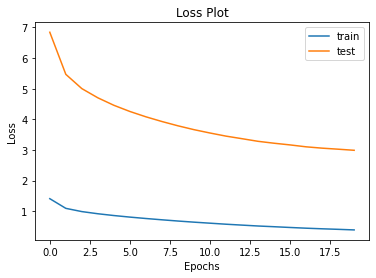

In [161]:
plt.plot(loss_plot, label='train')
plt.plot(test_loss_plot, label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(loc='upper right')
plt.show()

## Model Evaluation

In [153]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

**Define your evaluation function -**

In [154]:
def evaluate(image):
    batch_size=1
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[i] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]

    return result, attention_plot

In [155]:
def plot_attention(image, result, attention_plot):
    fig = plt.figure(figsize=(10, 10))
    temp_image = np.array(Image.open(image))
    
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Generate caption for a random image from the test set

BELU score: 81.3288280848893
Real Caption: basketball player for miami pushes forward
Prediction Caption: basketball player holds the ball


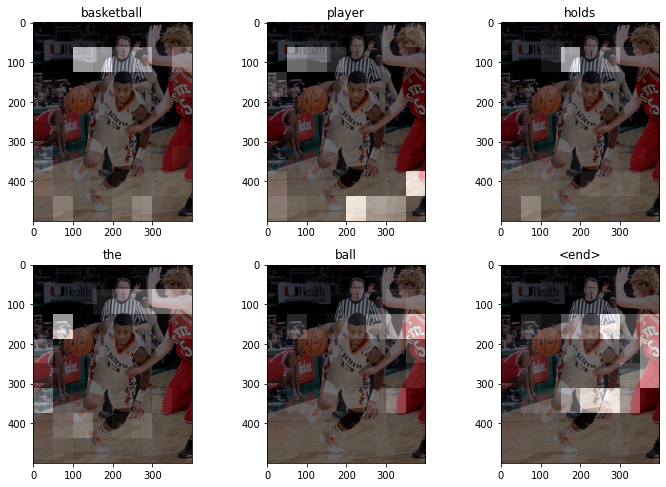

time took to Predict: 1 sec


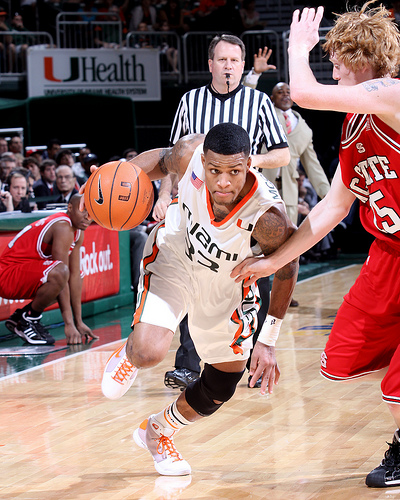

In [164]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
#result = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

score = sentence_bleu(real_caption, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])